In [1]:
from Sim_File_pd import sim_pd
from Event_Builder import BuildEvts
from PipeMaker import makepipe
from ConeMaker import makecone
from NozzleMaker import makenozz
from shutil import copyfile
import numpy as np
import glob
import os
import re
import math
import fnmatch
from CircleAreaCalc import area_calc, new_height_calc
import math
import matplotlib.pyplot as plt
from PIL import Image
from stopyt import desorb
import pickle
import warnings
from random import randrange
from massreader import readmass
import pandas as pd
from Plotter import plot

<img src="./Jupyter_Pics/solstise_logo.png" style="width: 700px;"/>

# **SOLSTISE Simulation Code Introduction**
Written for your enjoyment by Matt Hall (mhall12@alumni.nd.edu).

SOLSTISE is a gas jet target for use inside the SOLARIS magnet at the Facility for Rare Isotope Beams. This code will simulate the reaction kinematics and track the particles as they orbit in the magnetic field before they get detected. The reaction products will not be detected if they hit the gas jet infrastructure. This shadowing of the particles can then be assessed using various plots at the end of the code. 

The general structure of this Jupyter notebook is as follows:
1. An event file will be created using the Event_Builder.py code.
2. The jet infrastructure geometry (nozzle, receiver cone, gas return pipe) will then be set.
3. The shadowing simulation will be run, which propogates the particles through the magnetic field. 
4. Plots showing the shadowing and reaction products can be created.

Note: If this is your first time running the code, some directories will be made to contain the different files used in the simulation code. 

Note: If a solid target has been chosen, the geometry section can be skipped (though, the cells still need to be run).

In Event Builder, which is called in the background and not shown in the code below, the user must supply the reaction of interest (e.g. d(28Si,p)), the beam energy in MeV or MeV/u, and the direction that the particles will be detected in (upstream or downstream). Then, the user must either specify the specific energy levels to be populated, or enter 0 to simulate all energies for the levels up to a limit. 

If specific energy levels were specified, the user has two further options. They can either choose to use artificial smearing of the energies and angles of the reaction products or take a more realistic approach and calculate the energy loss and straggling in either a solid (CH$_2$ or CD$_2$) or gas jet target (H, He, etc). 

If the all energies option was used, no energy loss is assumed. This option should be used when the user wants to make contour plots of the reaction product shadowing at the end of the code. In general, I like to generate both an all energies event file, as well as a file with the individual levels specified. In Plotter, both of these files can be opened simultaneously and the file with the individual levels can be plotted on top of the contours.

First, let's run the Event Builder or open a pre-made event file: 

Tip: The user can just press "Enter" on the questions asking about the magnetic field, etc to use default values.

In [9]:
if not os.path.exists("Event_Files"):
    print("An Event_Files directory was not found, so one was created for you!\n")
    os.mkdir("Event_Files")

if not os.path.exists("Output_Files"):
    print("An Output_Files directory was not found, so one was created for you!\n")
    os.mkdir("Output_Files")

if not os.path.exists("Geometry_Files"):
    print("A Geometry_Files directory was not found, so one was created for you! \n")
    os.mkdir("Geometry_Files")

evtdir = "./Event_Files/"
geodir = "./Geometry_Files/"

defnozz = ".SOLSTISE_nozz_default.txt"
defcone = ".SOLSTISE_cone_3_2-6in.txt"

if not os.path.exists(geodir + defnozz[1:]):
    copyfile(defnozz, geodir + defnozz[1:])
    print("The default nozzle file was copied to the Geometry_Files directory!")
if not os.path.exists(geodir + defcone[1:]):
    copyfile(defcone, geodir + defcone[1:])
    print("The default receiver cone file was copied to the Geometry_Files directory!")

list_files = glob.glob(evtdir + '*evts*.txt')

if len(list_files) == 0:
    print("It appears that no event files exist, so we'll create one now!")
    filein = BuildEvts()
else:
    latest_file = max(list_files, key=os.path.getctime)
    latest_file = latest_file[14:]
    print("\nThe most recently created input file is: " + latest_file)
    yn = input("\nWould you like to use this file? [Y/N] ")

    if yn == "N" or yn == "n":
        newevtfileyn = input("Would you like to generate a new event simulation file? [Y/N] ")

        if newevtfileyn == "N" or newevtfileyn == "n":
            print("\n")
            for i in range(len(list_files)):
                print(str(i+1) + ") " + list_files[i][14:])

            filenum = 1000000
            while filenum > len(list_files):
                filenum = int(input("\nChoose a number from the list, or enter 0 to manually type the file name: "))

                if len(list_files) >= filenum > 0:
                    filein = list_files[filenum-1][14:]
                elif filenum > len(list_files):
                    print("ERROR: Number entered is greater than the number of simulation files...")
                else:
                    list_file2 = []
                    while len(list_file2) == 0:
                        filein = input("\nEnter the name of an existing input file (.dat or .txt): ")
                        list_file2 = glob.glob(evtdir + filein)

                        if len(list_file2) == 0:
                            print("\nERROR: The file does not exist...")
        else:
            filein = BuildEvts()
    else:
        filein = latest_file
        print(filein)

print("\nThe file to be used is: " + filein)

# Get the reaction out of the file name
# the locations of the underscores in the file name are found here and put into an array
uslocs = [m.start() for m in re.finditer('_', filein)]

reac = filein[:uslocs[0]] + "(" + filein[(uslocs[0]+1):uslocs[1]] + "," + filein[(uslocs[1]+1):uslocs[2]] + ")"

print("The reaction is: " + reac)

# Get the beam energy from the file name:

ebeam = int(filein[(uslocs[2]+1):uslocs[3]])

print("The beam energy is: " + str(ebeam) + " MeV")

try:
    bfield = float(input("\nEnter the magnetic field strength in Tesla: "))
except ValueError:
    bfield = 2.0

try:
    beamdia = float(input("\nEnter the beam diameter (FWHM) to be used in the simulation in mm: "))
except ValueError:
    beamdia = 1
    
beamdiamm = beamdia

if not fnmatch.fnmatch(filein, '*eloss*'):
    try:
        jetrad = float(input("\nEnter the jet radius in mm (typical values are on the order of 1.0 to 1.75 mm): "))
    except ValueError:
        jetrad = 1.25
else:
    jetrad = 0

jetrin=jetrad
    
try:
    detzi = float(input("\nEnter the distance from the target that the detector array should start in m: "))
except ValueError:
    detzi = 0.2

# need to load the file into a numpy array to do genfromtxt to determine whether or not the reaction is going to be
# measured in normal or inverse kinematics, then ask which way the return pipe is facing. If the pipe is facing the
# opposite direction, we'll just skip over the pipe definition and make the radius of the pipe tiny so it doesn't
# interfere with the reaction products...

datas = np.genfromtxt(evtdir + filein)
if datas[:, 0].mean() > 90:
    invkin = 1
else:
    invkin = 0


The most recently created input file is: d_28Si_p_177_evts_allE.txt

Would you like to use this file? [Y/N] y
d_28Si_p_177_evts_allE.txt

The file to be used is: d_28Si_p_177_evts_allE.txt
The reaction is: d(28Si,p)
The beam energy is: 177 MeV

Enter the magnetic field strength in Tesla: 2

Enter the beam diameter (FWHM) to be used in the simulation in mm: 1

Enter the jet radius in mm (typical values are on the order of 1.0 to 1.75 mm): 1

Enter the distance from the target that the detector array should start in m: 


_____________
# Geometry Definition
__________________
If you created a new file, it was saved in the ./Event_Files directory. It can now be read in the rest of the code, or used later on.

Now, the geometry parameters of the jet infrastructure (nozzle, receiver cone, and pipe) need to be generated. Below is a drawing of the setup with the different components labeled. There are default option for each component, or the user can generate custom components below.

Note: in the coordinate system we're using for the simulation, the z-axis points in the beam direction, the y-axis points up toward the nozzle, and the x-axis points beam right.

<img src="./Jupyter_Pics/SolstiseLabeledDrawing.PNG" alt="Drawing" style="width: 1000px;"/>

The first piece of the geometry we will define is the return pipe at the bottom of the solenoid. The vertical portion of the pipe directly below the receiver cone will always shadow some particles. However, if the horizontal portion of the pipe at the bottom of the solenoid is in the same half of the magnet as the detectors, some of the particles will be shadowed by this as well. In this case, to reduce the shadowing, the shape of the pipe can be altered. 

If a custom pipe is being made, we'll use a simplified geometry to mke the calculation a little easier (the below Figure is for reference). We'll define the upper boundary of the pipe as a second circle ($r_2$). The area_calc function will then calculate what the height of the 2nd circle has to be from the bottom of the bore to keep the cross-sectional area the same as an ISO-160 pipe. The code below will ask for the radius of the 2nd circle -- the larger the radius, the flatter the "pipe" will be on the top. Try starting with 3 meters and rerun the cell if you'd like to change that radius. 

In addition, you can specify the angle for the walls of the pipe. If the angle you specify is too large (i.e. the top of the new pipe would be over the height of the ISO-160 pipe), you will be asked for another angle. Since the pipe is symmetric, only one angle $\theta_1$ needs to be specified. 

<img src="./Jupyter_Pics/NewPipePic.png" alt="Drawing" style="width: 500px;"/>

Any custom pipe you create will be saved as its own pipe file, who's name is formatted PipeOut_2nd Circle radius_pipe angle.txt.

To define the pipe, run the cell below:

In [3]:
### The following code is from the SOLSTISE_Sim.py and includes the PipeMaker.py code for illustration.

# Remove this question if the user is using a solid target:
newpipe = 0
if not fnmatch.fnmatch(filein, '*eloss_s*'):
    try:
        pipefb = int(input("\nIs the pipe for the gas return in the downstream (0) or upstream (1) half of the "
                           "magnet?: "))
    except ValueError:
        pipefb = 0
else:
    pipefb = 0

if pipefb != invkin:
    pipeyn = 'n'
else:
    pipeyn = input("\nWould you like to use a custom shaped pipe for the gas return? [Y/N] ")

# Below, an ISO-160 pipe at the bottom of the magnet is defined.
if pipeyn == "N" or pipeyn == "n":

    hors = 0

    while hors != 1 and hors != 2:
        try:
            hors = int(input("\nWill the reaction be occurring in HELIOS (Enter 1) or SOLARIS (Enter 2)? "))
        except ValueError:
            hors = 1

        if hors != 1 and hors != 2:
            print("\nERROR: Unknown entry...")

    if hors == 1:
        r1 = 0.92 / 2
    else:
        r1 = 0.9 / 2

    if pipefb != invkin:
        piper = 0.001
        pipecenter = -r1
        phi1 = 3/2*math.pi
        phi2 = 3/2*math.pi
    else:
        piper = 0.152908/2
        pipecenter = 0.152908/2-r1
        phi1 = (180 + 90)*math.pi/180 - math.asin(piper/pipecenter)
        phi2 = 2*math.pi - (phi1 - math.pi)
    
    rbore = r1
    rblock = piper
    cheight = pipecenter
    phi1block = phi1
    phi2block = phi2
    
else:
    list_pipe_files = glob.glob(geodir + 'PipeOut*.txt')

    if len(list_pipe_files) == 0:
        print("\nNo pipe setup file exists in your directory, so we'll make one now.")
        newpipe = 1
    else:
        latest_pipe_file = max(list_pipe_files, key=os.path.getctime)
        latest_pipe_file = latest_pipe_file[17:]
        print("\nThe most recently created pipe setup file is: " + latest_pipe_file)
        pfileyn = input("\nWould you like to use this file? [Y/N] ")
        if pfileyn == "N" or pfileyn == "n":
            pfileyn2 = input("Would you like to generate a new custom pipe input file? [Y/N] ")
            if pfileyn2 == "N" or pfileyn2 == "n":
                print("\n")
                for i in range(len(list_pipe_files)):
                    print(str(i + 1) + ") " + list_pipe_files[i][17:])

                filenum = 1000000
                while filenum > len(list_pipe_files):
                    filenum = int(input("\nChoose a number from the list, or enter 0 to manually type the file name: "))

                    if len(list_pipe_files) >= filenum > 0:
                        pipedeffile = list_pipe_files[filenum - 1][17:]
                    elif filenum > len(list_pipe_files):
                        print("ERROR: Number entered is greater than the number of simulation files...")
                    else:
                        list_file_check = []
                        while len(list_file_check) == 0:
                            pipedeffile = input("Enter the name of the pipe input file: ")
                            list_file_check = glob.glob(geodir + pipedeffile)
                            if len(list_file_check) == 0:
                                print("ERROR: The file does not exist...")
            else:
                print("\nNow the SOLSTISE pipe will be defined. It is bounded by two circles of radius r1 and r2,")
                print("as well as two angles \u03B8\u2081 and \u03B8\u2082.")

                hors = 0

                while hors != 1 and hors != 2 and hors != 333:
                    try:
                        hors = int(input("\nWill the reaction be occurring in HELIOS (Enter 1) or SOLARIS (Enter 2)? "))
                    except ValueError:
                        hors = 0

                    if hors != 1 and hors != 2 and hors != 333:
                        print("\nERROR: Unknown entry...")

                if hors == 1:
                    r1 = 0.92 / 2
                else:
                    r1 = 0.9 / 2

                #plt.ion()
                %matplotlib notebook
                circle1 = plt.Circle((0, 0), r1, ec='black', color='white')

                # ISO 160 pipe dia in m
                pipedia = 5.83 * 2.54 / 100
                pipecenter = pipedia / 2 - r1
                circlepipe = plt.Circle((0, pipecenter), pipedia / 2, ec='black', fill=False)

                fig, ax = plt.subplots()
                ax.add_artist(circle1)
                ax.add_artist(circlepipe)
                ax.axis('equal')
                ax.set_xlim((-.5, .5))
                ax.set_ylim((-.7, .4))
                #fig.show()

                # matplotlib spits out some warnings and errors that can be ignored, but print the radius and require an 
                # because otherwise the error goes at the end of the next .
                input("The radius is " + str(r1) + " m. Press ENTER to continue.")
                while True:
                    try:
                        r2 = float(input("\nEnter the radius of the 2nd circle in meters (or enter 0 for inches): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")

                if r2 == 0:
                    while True:
                        try:
                            r2in = float(input("\nEnter the radius of the 2nd circle in inches: "))
                            break
                        except ValueError:
                            print("ERROR: Your entry is invalid. Please try again. \n")
                    r2 = r2in * 2.54 / 100

                ang1, h = area_calc(r1, r2)

                circle2 = plt.Circle((0, h), r2, ec='red', fill=False)
                plt.gcf().gca().add_artist(circle2)
                #fig.show()

                ang1deg = ang1 * 180 / math.pi

                if ang1deg > 270:
                    ang1deg = 360 - (ang1deg - 180)

                ang2deg = 360 - (ang1deg - 180)

                print("The circle intersection points are", int(ang1deg), "degrees and", int(ang2deg), "degrees")

                try:
                    yn2 = input("\nWould you like to use new angles for the pipe geometry? (Y/N) ")
                except ValueError:
                    yn2 = "Y"

                pipethickcheck = .15
                iso160pipedia = .148082
                c2height = 0.0
                angin = 0
                anginrad = 0
                angin2 = 0
                angin2rad = 0

                if yn2 == "N" or yn2 == "n":
                    # anglist.append(ang1)
                    angin = ang1deg

                    anginrad = angin * math.pi / 180
                    angin2 = 360 - (angin - 180)
                    angin2rad = angin2 * math.pi / 180

                    c2height = h

                else:
                    circle2.set_visible(False)
                    # It has to be less than 270 because that's the bottom of the circle. Actually, 270 is also dumb because
                    # the pipe would block the entire path then.
                    print("\nNote: the new angle must be greater than", int(ang1deg), "and less than 270 degrees.")

                    while (angin < ang1deg or angin > 270) or pipethickcheck > iso160pipedia:
                        angin = float(input("\nInput the new angle (in degrees): "))
                        if angin < ang1deg:
                            print("Error: The angle must be greater than", int(ang1deg), "and less than 270 degrees.")
                        elif angin > ang1deg:
                            c2height = new_height_calc(r1, r2, angin)
                            pipethickcheck = r1 - r2 + c2height
                            if pipethickcheck > iso160pipedia:
                                print("Error: The calculated pipe height is", pipethickcheck, "m.")

                    anginrad = angin * math.pi / 180
                    angin2 = 360 - (angin - 180)
                    angin2rad = angin2 * math.pi / 180

                    circle3 = plt.Circle((0, c2height), r2, ec='red', fill=False)
                    plt.gcf().gca().add_artist(circle3)
                    x1, y1 = [0, r1 * math.cos(anginrad)], [0, r1 * math.sin(anginrad)]
                    x2, y2 = [0, r1 * math.cos(angin2rad)], [0, r1 * math.sin(angin2rad)]
                    plt.plot(x1, y1, x2, y2, color='red')

                fname = "PipeOut_" + str(int(r2)) + "_" + str(int(angin)) + ".txt"

                params = [r1, r2, c2height, anginrad, angin2rad]

                # ("\nPress ENTER to continue.")

                geodir = "./Geometry_Files/"

                file = open(geodir + fname, "w+")

                # Build the pipe setup file here
                for i in range(5):
                    file.write(str(params[i]) + "\n")

                print("An output file named " + fname + " was created in " + geodir + " !")
                print("The custom pipe you made can be viewed above!")

                file.close()

                # final pipe geometry is defined by anglist[], r1 ,r2, and the output of new_height_calc, which is the
                # height of the 2nd circle above the x-axis (c2height)

                # The equation of an offset circle in cylindrical coordinates rho = d*sin(th) + Sqrt(d^2 sin(th)^2 - d^2 + r^2)
                # for a normal circle, rho = r
                
                pipedeffile = fname
        else:
            pipedeffile = latest_pipe_file

    file = open(geodir + pipedeffile, "r")

    lines = file.readlines()
    
    rbore = float(lines[0])
    rblock = float(lines[1])
    cheight = float(lines[2])
    phi1block = float(lines[3])
    phi2block = float(lines[4])


Is the pipe for the gas return in the downstream (0) or upstream (1) half of the magnet?: 0

Will the reaction be occurring in HELIOS (Enter 1) or SOLARIS (Enter 2)? 1


___________________________
Next, we'll define the nozzle to be used in the simulation. A default nozzle file is already included in the download. However, if you want to make a custom nozzle it can be done below. Next, run the following cell to either choose the default nozzle file or make your own.

Below is a drawing of the nozzle and holder, outlining the various dimensions you will need to generate your own nozzle. If you don't have a nozzle CAD file to get dimensions from, you will want to use the default file.

<img src="./Jupyter_Pics/NozzleFig.png" alt="Drawing" style="width: 600px;"/>



In [4]:
if not fnmatch.fnmatch(filein, '*eloss_s*'):
    try:
        nozzopt = int(input("\nWould you like to use the default SOLSTISE nozzle (0) or a custom-shaped nozzle (1)?: "))
    except ValueError:
        nozzopt = 0
else:
    nozzopt = 0

if nozzopt == 0:
    nozztxt = 'SOLSTISE_nozz_default.txt'
else:
    list_nozz = glob.glob(geodir + '*nozz*.txt')
    latest_nozz = max(list_nozz, key=os.path.getctime)
    latest_nozz = latest_nozz[17:]
    print("\nThe most recently created nozzle input file is: " + latest_nozz)
    yn = input("\nWould you like to use this file? [Y/N] ")

    if yn == 'n' or yn == 'N':
        newnozzyn = input("Would you like to create a new nozzle input file? [Y/N] ")

        if newnozzyn == 'n' or newnozzyn == 'N':
            print("\n")
            for i in range(len(list_nozz)):
                print(str(i + 1) + ") " + list_nozz[i][17:])

            filenum = 1000000
            while filenum > len(list_nozz):
                filenum = int(input("\nChoose a number from the list, or enter 0 to manually type the file name: "))

                if len(list_nozz) >= filenum > 0:
                    nozztxt = list_nozz[filenum - 1][17:]
                elif filenum > len(list_nozz):
                    print("ERROR: Number entered is greater than the number of nozzle input files...")
                else:
                    list_file_check = []
                    while len(list_file_check) == 0:
                        nozztxt = input("Enter the name of the nozzle input file: ")
                        list_file_check = glob.glob(geodir + nozztxt)
                        if len(list_file_check) == 0:
                            print("ERROR: The file does not exist...")
        else:
            # Code for defining nozzle parameters. The information from the text file is then
            # used in the main simulation code to define the nozzle for shadowing..

            # Distance below the nozzle that the reaction occurs (output in mm):
            while True:
                try:
                    reacdist = float(input("Enter the distance that the reactions occur below the nozzle in mm (Enter 0 for "
                                           "inches): "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if reacdist == 0:
                while True:
                    try:
                        reacdistin = float(input("Enter the distance in inches: "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                reacdist = reacdistin * 2.54 * 10

            # Nozzle opening diameter in inches
            while True:
                try:
                    nozzdia = float(input("Enter the nozzle exhaust opening diameter in mm (Enter 0 for in): "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            if nozzdia > 0:
                nozzdia = nozzdia / 10 / 2.54
            elif nozzdia == 0:
                while True:
                    try:
                        nozzdia = float(input("Enter the diameter in inches: "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")

            # Angle the outside of the nozzle makes from vertical.
            print("The outside of the nozzle is defined from the exhaust and up, "
                  "using a cone shape and then a cylindrical shape.")

            while True:
                try:
                    nozzang = float(input("Enter the angle in degrees that the nozzle cone makes with the vertical axis: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            # Output this one in m so we don't need to convert again.
            while True:
                try:
                    nozzconelen = float(input("Enter the distance from the cone exhaust to the "
                                            "cylindrical neck portion in mm (Enter 0 for inches): "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            if nozzconelen == 0:
                while True:
                    try:
                        nozzconelen = float(input("Enter the distance in inches: "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")

                nozzconelen = nozzconelen * 2.54 / 100
            elif nozzconelen > 0:
                nozzconelen = nozzconelen / 1000

            nozzcyldia = 2 * nozzconelen * math.tan(nozzang * math.pi/180) + nozzdia * 2.54 / 100
            print("The nozzle cylinder diameter was calculated to be: ", nozzcyldia * 1000, " mm.")

            try:
                chyn = input("Would you like to change the calculated cylinder diameter? [Y/N] ")
            except ValueError:
                chyn = "N"

            if chyn == "Y" or chyn == "y":
                while True:
                    try:
                        nozzcyldia = float(
                            input("Enter the diameter of the nozzle cylinder (above the cone) in mm (Enter 0 for inches): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                if nozzcyldia == 0:
                    while True:
                        try:
                            nozzcyldia = float(input("Enter the diameter in inches: "))
                            break
                        except ValueError:
                            print("ERROR: Your entry is invalid. Please try again. \n")
                    nozzcyldia = nozzcyldia * 2.54 / 100
                elif nozzcyldia > 0:
                    nozzcyldia = nozzcyldia / 1000

            # Nozzle cylinder height is in m
            while True:
                try:
                    nozzcylh = float(input("Enter the distance from the bottom of the nozzle cylinder to the bottom of the "
                                           "nozzle holder in mm (Enter 0 for inches): "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzcylh == 0:
                while True:
                    try:
                        nozzcylh = float(input("Enter the distance in inches: "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                nozzcylh = nozzcylh * 2.54 / 100
            elif nozzcylh > 0:
                nozzcylh = nozzcylh / 1000

            print("Now, we'll define the nozzle holder. The holder is made of a cylinder and a box portion.")

            # Diameter of the nozzle holder is also in m
            while True:
                try:
                    nozzholderdia = float(input("Enter the diameter of the nozzle holder cylinder in mm (default is 19.05 mm) "
                                                "or enter 0 for inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzholderdia > 0:
                nozzholderdia = nozzholderdia / 1000
            elif nozzholderdia == 0:
                while True:
                    try:
                        nozzholderdia = float(input("Enter the diameter in inches (default is 0.75 in): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                nozzholderdia = nozzholderdia * 2.54 / 100

            # default holder height is 1.15 in, should be in m

            while True:
                try:
                    nozzholderheight = float(input("Enter the height of the nozzle holder cylinder in mm (default is 29.2 mm) "
                                                   "or enter 0 for inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzholderheight == 0:
                while True:
                    try:
                        nozzholderheight = float(input("Enter the height in inches (default is 1.15 in): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                nozzholderheight = nozzholderheight * 2.54 / 100
            elif nozzholderheight > 0:
                nozzholderheight = nozzholderheight / 1000

            while True:
                try:
                    nozzboxstart = float(input("Enter the distance between the bottom of the holder cylinder \n"
                                               "and the bottom of the holder box in mm (default is 5.08 mm) or enter 0 for "
                                               "inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzboxstart == 0:
                while True:
                    try:
                        nozzboxstart = float(input("Enter the distance in inches (default is 0.2 in): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                nozzboxstart = nozzboxstart * 2.54 / 100
            elif nozzboxstart > 0:
                nozzboxstart = nozzboxstart / 1000

            while True:
                try:
                    nozzboxh = float(input("Enter the height of the box in mm (default is 19.05 mm) or enter 0 for inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzboxh == 0:
                while True:
                    try:
                        nozzboxh = float(input("Enter the distance in inches (default is 0.75 in): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")

                nozzboxh = nozzboxh * 2.54 / 100
            elif nozzboxh > 0:
                nozzboxh = nozzboxh / 1000

            while True:
                try:
                    nozzboxl = float(input("Enter the (side-to-side) width of the box in mm (default is 43.142 mm) or "
                                           "enter 0 for inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzboxl == 0:
                while True:
                    try:
                        nozzboxl = float(input("Enter the length in inches (default is 1.7 in): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")
                nozzboxl = nozzboxl * 2.54 / 100
            elif nozzboxl > 0:
                nozzboxl = nozzboxl / 1000

            while True:
                try:
                    nozzboxw = float(input("Enter the (back-to-front) length of the box in mm (default is 14.199 mm) or "
                                           "enter 0 for inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")
            if nozzboxw == 0:
                while True:
                    try:
                        nozzboxw = float(input("Enter the distance in inches (default is 0.559 in): "))
                        break
                    except ValueError:
                        print("ERROR: Your entry is invalid. Please try again. \n")

                nozzboxw = nozzboxw * 2.54 / 100
            elif nozzboxw > 0:
                nozzboxw = nozzboxw / 1000

            params = [reacdist, nozzdia, nozzang, nozzconelen, nozzcyldia, nozzcylh, nozzholderdia, nozzholderheight,
                      nozzboxstart, nozzboxh, nozzboxl, nozzboxw]

            geodir = "./Geometry_Files/"
            fname = "cust_nozz_" + str(int(nozzang)) + "deg.txt"

            file = open(geodir + fname, "w+")

            for i in params:
                file.write(str(i) + "\n")

            print("A custom nozzle file was created with the name " + fname + "!")

            nozztxt = fname
    else:
        nozztxt = latest_nozz


Would you like to use the default SOLSTISE nozzle (0) or a custom-shaped nozzle (1)?: 0


________________________________________
Now that the pipe and nozzle have been defined, the final piece of the puzzle is defining the receiver cone. This step is a little more complicated and takes some effort outside the code. Since we want to allow for different cone shapes, we need to come up with a way to correlate the y-position and the radius of the receiver cone. When done this way, we can simply take the y-position of the reaction product, calculate the position in the x-z plane, and determine whether or not the particle is inside the radius of the cone.

To do this, we will take a series of (y,r) points along the side of the cone, and fit these points with a polynomial (see figure below for example). The code can accept up to 3rd order polynomials.

<img src="./Jupyter_Pics/ConeDiagram.png" alt="Drawing" style="width: 800px;"/>

In [5]:
if not fnmatch.fnmatch(filein, '*eloss_s*'):
    try:
        coneopt = int(input("\nWould you like to use the default SOLSTISE cone (0) or a custom cone (1)?: "))
    except ValueError:
        coneopt = 0
else:
    coneopt = 0

if coneopt == 0:
    conetxt = "SOLSTISE_cone_3_2-6in.txt"

else:
    list_cones = glob.glob(geodir + '*cone*.txt')
    latest_cone = max(list_cones, key=os.path.getctime)
    latest_cone = latest_cone[17:]
    print("\nThe most recently created cone input file is: " + latest_cone)
    yn = input("\nWould you like to use this file? [Y/N] ")

    if yn == 'n' or yn == 'N':
        newconeyn = input("Would you like to create a new cone input file? [Y/N] ")

        if newconeyn == 'n' or newconeyn == 'N':
            print("\n")
            for i in range(len(list_cones)):
                print(str(i + 1) + ") " + list_cones[i][17:])

            filenum = 1000000
            while filenum > len(list_cones):
                filenum = int(input("\nChoose a number from the list, or enter 0 to manually type the file name: "))

                if len(list_cones) >= filenum > 0:
                    conetxt = list_cones[filenum - 1][17:]
                elif filenum > len(list_cones):
                    print("ERROR: Number entered is greater than the number of cone input files...")
                else:
                    list_file_check = []
                    while len(list_file_check) == 0:
                        conetxt = input("Enter the name of the cone input file: ")
                        list_file_check = glob.glob(geodir + conetxt)
                        if len(list_file_check) == 0:
                            print("ERROR: The file does not exist...")
        else:
            # Code for defining cone parameters and fitting parameters. The information from the text file is then
            # used in the main simulation code to define the cone.

            print("Here, you will define some of the setup parameters, including the shape of the receiver cone. \n")

            # Distance from the nozzle to the cone in Inches
            while True:
                try:
                    conenozzdist = float(input("\nEnter the distance from the bottom of the nozzle to the top of the cone "
                                               "in inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            while True:
                try:
                    coneheight = float(input("\nEnter the cone height in inches, from the top of the ISO-100 cylinder"
                                             " to the top of the cone: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            while True:
                try:
                    iso160height = float(input("\nEnter the distance from the bottom of the nozzle to the top of the "
                                               "ISO-160 base in inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            # Outer diameter of the top of the cone
            while True:
                try:
                    conedia = float(input("\nEnter the outer diameter of the top of the cone in inches: "))
                    break
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

            print("\nThe side of the cone is described by a polynomial (up to order 3) of the form: radius = a_i * y^i, "
                  "\n where y and radius are in inches. The y-distance is defined as 0 at the top of the cone and"
                  "\nincreases going down the cone. \n")

            hp = input("Confused? For a helpful image, enter H now. Otherwise, press ENTER to continue: ")

            if hp == "H" or hp == "h":
                plt.ion()
                img = mpimg.imread("./Jupyter_Pics/ConeDiagram.png")
                imgplot = plt.imshow(img)
                plt.show()
                plt.ioff()

                print("\n\n")
                print("The image demonstrates how the fitting should be done. As mentioned, \n"
                      "you can use a polynomial up to order 3 here. \n\n")

            # set polyorder to some high value so that the user gets stuck in the while loop until they enter 3 or less.
            polyorder = 4
            while polyorder > 3 or polyorder < 1:
                try:
                    polyorder = int(input("Please enter the order of the polynomial you'd like to use to "
                                          "describe the sides of the cone (max 3): "))
                except ValueError:
                    print("ERROR: Your entry is invalid. Please try again. \n")

                if polyorder > 3:
                    print("\nERROR: The maximum order of the polynomial is 3... ")
                if polyorder < 1:
                    print("\nERROR: The minimum order of the polynomial is 1... ")

            # Convert conedia into a string and replace the . with a - to put it in the pickle file name
            conediastring = str(conedia)
            conediastring = conediastring.replace('.', '-')

            # Add all the input parameters to a new list called coneparms:
            coneparms = [conenozzdist, coneheight, iso160height, conedia, polyorder]

            # In the for loop, add 0's for the coefficients not being used and let the user
            # input coefficients for the ones that are.
            for i in range(4):
                expon = 3 - i

                if polyorder < expon:
                    coneparms.append(0)
                else:
                    while True:
                        try:
                            coneparms.append(float(input("Enter the coefficient on the y^" + str(expon) +
                                                         " term (include the sign!): ")))
                            break
                        except ValueError:
                            print("\n ERROR: The coefficient you entered is not valid.")

            geodir = "./Geometry_Files/"
            fname = "cust_cone_" + str(polyorder) + "_" + conediastring + "in.txt"

            file = open(geodir + fname, "w+")

            for i in coneparms:
                file.write(str(i) + "\n")

            print("A file named ", fname, " was saved to ", geodir)

            conetxt = fname
    else:
        conetxt = latest_cone


Would you like to use the default SOLSTISE cone (0) or a custom cone (1)?: 0


___________________________
# Particle Propogation Through the Field
____________________________________
Now that the cone, nozzle, and receiver cone have been specified (or you skipped the Geometry section because you're using a solid target) we can now go ahead and propogate our particles through the magnetic field below. 

<img src="./Jupyter_Pics/ParticleTrack.png" alt="Drawing" style="width: 800px;"/>

In the above picture, the magenta line is an example of the helical path a particle will take in the magnetic field. As you can imagine, depending on the energy and angle of the particle, it's possible that it will hit one of the components of the jet infrastructure. The following code takes the event, target, and geometry files created above and propogates the particles through the field. The orbital period is broken up into 300 segments and each particle's x, y, and z positions are checked and compared to the geometry of the jet infrastructure. If the particle is found to be within any of these volumes, it is flagged as being shadowed.

This process takes a few minutes depending on the size of the chosen event file, but once the progress bar indicates the tracking portion is complete, you can move on to the next step.

In [10]:
# suppress warnings that occur in the code calculations:
warnings.filterwarnings("ignore")

evtdir = "./Event_Files/"
outdir = "./Output_Files/"
geodir = "./Geometry_Files/"

# Open the targetparms pkl:
# targetparms now contains all the information needed for the desorb calculation.
if fnmatch.fnmatch(filein, '*eloss*'):
    pklname = filein[:-16] + 'tgt_' + filein[-5] + '.pkl'

    with open(evtdir + pklname, 'rb') as f:
        targetparms = pickle.load(f)

    # The list has to contain other lists, so many of the parameters will require [][0]
    ebeam = targetparms[9][0]

    # Put the targetparms into useful variables:
    ztarg = targetparms[0]
    atarg = targetparms[1]
    numtarg = targetparms[2]
    density = targetparms[3][0]
    thickness = targetparms[4][0]
    jetpress = targetparms[5][0]
    jetrad = targetparms[6][0]
    champress = targetparms[7][0]
    gas = targetparms[8][0]
    if len(targetparms) == 12:
        ex1 = targetparms[10][0]
        ex2 = targetparms[11][0]
    else:
        ex1 = 1
        ex2 = 2
        print("***You're using an old file, so the Excitation Energy calculation will not work correctly!***")

    elossbool = True
else:
    elossbool = False
    thickness = 'N/A'
    jetpress = 'N/A'
    champress = 'N/A'
    jetrad = 'N/A'

if rblock < rbore:
    phi1block = 3/2*np.pi - np.arctan(rblock/(-1*cheight))
    phi2block = 3/2*np.pi + np.arctan(rblock/(-1*cheight))

# Control which way the reaction products bend in the field based on the solenoid.
# HELIOS particles bend CCW looking downstream at target, Ben thinks they go the same way in SOLARIS, but it can be
# changed here easily if need be. cwsign = -1 is CCW, cwsign = 1 is CW.:
# HELIOS
if rbore == 0.46:
    cwsign = -1
# SOLARIS
if rbore == 0.45:
    cwsign = -1
else:
    cwsign = -1

# The z axis points in beam direction, the x-axis points to beam right, and the y-axis points up
# Get the various parameters from readmass. In this case, we don't actually want z/atarg to be defined here
# because they'll be wrong if it's a solid target
masses, ztarg_buff, atarg_buff, zeject, aeject, zbeam, abeam, buff = readmass(reac)

# reaction of form t(b,e)R
utoMeV = 931.4941

mt = masses[0]
mb = masses[1]
me = masses[2]
mr = masses[3]

mevtoj = 1.6021766e-13
c = 2.998e8

qvalnoex = (mt + mb - me - mr)*utoMeV

#ebeam = 168 # MeV, for d(28Si,p) it is 6 MeV/u

rblock = np.array(rblock, dtype=np.float64)
cheight = np.array(cheight, dtype=np.float64)
phi1block = np.array(phi1block, dtype=np.float64)
phi2block = np.array(phi2block, dtype=np.float64)

# finite radius of the detector array
r0 = 0.011

#tcm is a constant
tcm = mt/(mb+mt)*ebeam

amutokg = 1.66053907e-27  # amu to kg conversion
B = bfield
# B = 1.915  # teslas
q = 1.6e-19  # 1 elemental charge in coulombs

# Generates a pandas data frame of shape (xxx,2) whose columns are theta angle and energy.
df = pd.read_csv(evtdir + filein, sep="\t", header=None, low_memory=False)
if not fnmatch.fnmatch(filein, '*eloss*'):
    df.columns = ["Theta_Deg", "Energy"]
else:
    if fnmatch.fnmatch(filein, '*_g*'):
        # If it's an eloss text file, we have an additional column,
        # which is thickness for a solid or z offset for a jet.
        df.columns = ["Theta_Deg", "Energy", "z_Offset"]
    elif fnmatch.fnmatch(filein, '*_s*'):
        df.columns = ["Theta_Deg", "Energy", "Tgt_Thick"]

# Determine whether or not the particles are coming out at backward or forward angles:
if df["Theta_Deg"].mean() > 90:
    invkin = True
else:
    invkin = False

# Convert the angle to radians and add it to the dataframe
df['Theta_Rad'] = df['Theta_Deg'] * np.pi/180

# makes a phi array the same size as the theta array, random number 0 to 1
phi = np.random.rand(len(df))
# then multiply the phi array by 2pi to get a real phi value and put it into the dataframe
df['Phi'] = phi * 2 * np.pi
# Phi for debugging
# df['Phi'] = np.zeros_like(df['Energy']) + np.pi

# this initializes phic, which tracks the current position of the phi particle.
phic = df['Phi']

# Grab the max energy before the eloss section because sometimes we get one really large value that messes up the
# histogram ranges in plotter...
maxe = df['Energy'].max()

# ELOSS HERE
if elossbool:
    print("\nNow calculating the energy loss of the reaction products...")
    # Need to set up the projectile data here that goes into desorb:
    zp = np.zeros_like(phic) + zeject
    ap = np.zeros_like(phic) + aeject
    proj_e = df['Energy'].to_numpy()

    emaxinit = df['Energy'].max()

    # Make an empty data frame to store the output:
    df_elossout = pd.DataFrame()
    proj_ein = proj_e

    if gas:
        # Set the jet radius here, gets set from targetparms. Redefinition could be removed:
        jetr = jetrad / 100
        # zoff is now the z offset in m.
        zoff = df['z_Offset'].to_numpy() / 100.0 - jetr

        jetroff = zoff
        jetroff = np.where(zoff < -jetr, -jetr, jetroff)
        jetroff = np.where(zoff > jetr, jetr, jetroff)

        # The distance that the particle must traverse to get out of the jet is set here.
        jetlength = np.abs(
            jetr / np.sqrt(np.sin(df['Theta_Rad'].to_numpy()) ** 2 * np.cos(df['Phi'].to_numpy()) ** 2 +
                        np.cos(df['Theta_Rad'].to_numpy()) ** 2) + jetroff /
            np.sqrt(np.sin(df['Theta_Rad'].to_numpy()) ** 2 * np.cos(df['Phi'].to_numpy()) ** 2 +
                    np.cos(df['Theta_Rad'].to_numpy()) ** 2))

        # convert jetlength to cm:
        jetlength = jetlength * 100.0

        df_elossout = desorb(zp, ap, proj_ein, ztarg, atarg, numtarg, gas, 0, 0, jetpress, jetlength,
                                proj_e)

        proj_ein = df_elossout['Energy_i'].to_numpy() - df_elossout['DeltaE_tot'].to_numpy()

    if not gas:
        zoff = np.zeros_like(df['Energy'].to_numpy())

        print("\nYou're using a solid target, so the energy loss calculation is going to take a minute or two...")

        if invkin:
            # If in inverse kinematics, we want the target thickness to be the thickness traversed by the beam,
            # which is what we get from event builder.
            indthickness = df['Tgt_Thick'].to_numpy() / np.sin(df['Theta_Rad'].to_numpy() - np.pi/2)
        else:
            # If in normal kinematics, we want to subtract the thickness seen by the beam from the target thickness
            # So, if the beam sees 0.95 mg/cm^2 of a 1 mg/cm^2 target, the light ejectile will see 0.05 mg/cm^2
            indthickness = (thickness - df['Tgt_Thick'].to_numpy()) / np.sin(df['Theta_Rad'].to_numpy())

        # We don't need a for loop here because there's only one layer for the protons to lose energy
        df_elossout = desorb(zp, ap, proj_ein, ztarg, atarg, numtarg, gas, density, indthickness, 0, 0, proj_e)
        proj_e = df_elossout['Energy_i'].to_numpy() - df_elossout['DeltaE_tot'].to_numpy()

    estragtot = df_elossout['E_strag_FWHM'].to_numpy()

    df['Energy'] = np.random.normal(proj_e, estragtot)
else:
    zoff = np.random.normal(np.zeros_like(df['Energy'].to_numpy()), ((jetrin * 2) / 1000) / 2.355)

# Cyclotron frequency and period.
omega = (q * B) / (me * amutokg)
tcyc = (2 * np.pi) / omega

# Velocity of the ejectile in the lab frame (m/s) added to dataframe
df['vel_ejec'] = np.sqrt((2 * df['Energy'] * mevtoj) / (me * amutokg))
# Velocities parallel to the z-axis and perpendicular to the z-axis.
df['vel_perp'] = df['vel_ejec'] * np.sin(df['Theta_Rad'])
df['vel_par'] = df['vel_ejec'] * np.cos(df['Theta_Rad'])

# Calculates Q-Ex from the energy and angle of the ejected particle (Krane 11.10)
df['Q-Ex'] = df['Energy'] * (1 + me / mr) - ebeam * (1 - mb / mr) - 2 * np.sqrt(
    mb * me / mr**2 * df['Energy'] * ebeam) * np.cos(df['Theta_Rad'])

# The total energy of the reaction, Tcm + Q-value - Ex
df['E_tot'] = tcm + df['Q-Ex']

# The velocity of the ejectile in the CM frame.
df['v0'] = np.sqrt(2 * mr * utoMeV * df['E_tot'] / (me * utoMeV * (me * utoMeV + mr * utoMeV))) * c

# The velocity of the CM frame, it's a constant and dependent on the beam energy and species.
vcm = np.sqrt(2 * ebeam / (mb * utoMeV)) * (mb * utoMeV/(mb * utoMeV+mt * utoMeV)) * c

# Calculates the CM angle of the ejectile and recoil (they're the same). arccos takes values from -1 to 1 and won't
# break if it gets a value outside of that range.
# However, we'll get rid of all the NaN entries before the arccos line with a mask.
df['cosarg'] = (df['vel_ejec']**2 - df['v0']**2 - vcm**2)/(2 * df['v0'] * vcm)
maskarg = (df['cosarg'] >= -1) & (df['cosarg'] <= 1)

df = df[maskarg]

zoff = zoff[maskarg]
phic = phic[maskarg]
if elossbool:
    if gas:
        jetlength = jetlength[maskarg]

df = df.reset_index(drop=True)
#print(df)

df['Theta_CM'] = np.arccos((df['vel_ejec']**2 - df['v0']**2 - vcm**2)/(2 * df['v0'] * vcm))

# Reduced cyclotron frequency because of the finite size of the detector array.
df['t_reduced'] = tcyc - r0/(df['v0']*np.sin(df['Theta_CM']))

# creates a mask the same shape as the energy array

# maskmasters for the pipe and cone defined here.
maskmaster_pipe = df['Energy'] > 0
maskmaster_cone = df['Energy'] > 0
maskmaster_nozzle = df['Energy'] > 0
# maskrbore takes care of the mask for the bore radius because some particles will hit that
maskrbore = df['Energy'] > 0
# maskcone initialized like maskrbore
masknozzle = df['Energy'] > 0

# ***************************************************************************************
# ***************************************************************************************
# ***************************************************************************************
# ***************************************************************************************

# Parameters of the nozzle, cone, and pipe get entered here:

# Have to open the cone text file:
conefile = open(geodir + conetxt, "r")

# coneparms in order will have conenozzdist (in), coneheight (in), iso160height (in), conedia (in), polyorder,
# ^3 coeff, ^2 coeff, ^1 coeff, ^0 coeff
coneparms = conefile.readlines()

nozzfile = open(geodir + nozztxt, "r")

# nozzparms in order will have the reaction distance (mm), nozzle diameter (in), nozzle angle (deg), cone length (m)
# cylinder radius (m), cylinder height (m), holder radius (m), and holder height (m).
nozzparms = nozzfile.readlines()

nozzleconedistin = float(coneparms[0])  # dist between nozzle and cone in inches
reacdistbelownozzle = float(nozzparms[0]) / 10 / 2.54  # dist below nozzle the reaction happens in inches
nozzconelen = float(nozzparms[3])  # nozzle cone length in m
nozzcylrad = float(nozzparms[4]) / 2  # nozzle cylinder radius in m
nozzcylh = float(nozzparms[5])  # nozzle cylinder height in m
nozzholdrad = float(nozzparms[6]) / 2  # nozzle holder radius in m
nozzholdh = float(nozzparms[7])  # nozzle holder height in m

# Distance from the bottom of the nozzle holder to the bottom of the box
# Distance from the bottom of the box to the top of the box
nozzboxstart = float(nozzparms[8])
nozzboxh = float(nozzparms[9])

nozzholdcylstart = reacdistbelownozzle * 2.54 / 100 + nozzconelen + nozzcylh
nozzholdcylend = reacdistbelownozzle * 2.54 / 100 + nozzconelen + nozzcylh + nozzholdh
nozzholdboxstart = reacdistbelownozzle * 2.54 / 100 + nozzconelen + nozzcylh + nozzboxstart
nozzholdboxend = reacdistbelownozzle * 2.54 / 100 + nozzconelen + nozzcylh + nozzboxstart + nozzboxh

nozzboxhalfl = float(nozzparms[10]) / 2
nozzboxhalfw = float(nozzparms[11]) / 2

conedia = float(coneparms[3])  # cone outer diameter in inches
coneheight = float(coneparms[1])  # cone height in inches as measured from the top of the ISO-100 cylinder.

# Height above the cone that the reaction occurs
reacheight = ((nozzleconedistin - reacdistbelownozzle) * 2.54) / 100

conefitdist = reacheight + coneheight * 2.54 / 100

# In the new SOLSTISE designs, the ISO base isn't really present, so we'll make this the size of the bottom
# of the cone instead.
basedia = 4.2  # inches
riso100cyl = (basedia / 2) * 2.54 / 100

# distance from the reaction that the cone side equation starts (this equation starts at ~5.5, now 3.83).
# sideheight = (5.5 - reacdistbelownozzle) * 2.54 / 100
sideheight = (nozzleconedistin - reacdistbelownozzle) * 2.54 / 100

# Polynomial coefficients for the current best cone: Top of cone is 3.83 in away from nozzle

# poly3 = [0.0611, -0.8077, 3.5255, -3.7867]
poly3 = [float(coneparms[5]), float(coneparms[6]), float(coneparms[7]), float(coneparms[8])]

rconeside = lambda y: (poly3[0] * (y + reacdistbelownozzle - nozzleconedistin) ** 3 +
                        poly3[1] * (y + reacdistbelownozzle - nozzleconedistin) ** 2 +
                        poly3[2] * (y + reacdistbelownozzle - nozzleconedistin) + poly3[3]) * 2.54 / 100

# parameters for nozzle shadowing here:
nozzang = float(nozzparms[2]) * np.pi / 180  # the nozzle slope angle, which is 22 degrees (converted to rads)
nozzdia = float(nozzparms[1])

# feed it inches, gives back meters. Calc the nozzle radius at a specified y position height.
rnozzle = lambda y: (nozzdia / 2 + (y - reacdistbelownozzle) * np.tan(nozzang)) * 2.54 / 100

# function determines the r coordinates of the 2nd circle that makes up the gas pipe.
# Need pipepm to multiply rpipe by a minus sign if we are using an ISO 160 Pipe:
if rblock < rbore:
    pipepm = -1
else:
    pipepm = 1

rpipe = lambda ph: cheight*np.sin(ph) + pipepm * np.sqrt(cheight**2*np.sin(ph)**2 - cheight**2 + rblock**2)

# Distance from the reaction to the top of the vertical ISO160 Pipe in m
iso160pipeheight = (float(coneparms[2]) - reacdistbelownozzle) * 2.54 / 100

# ***************************************************************************************
# ***************************************************************************************
# ***************************************************************************************
# ***************************************************************************************

# The last position of the particle, to determine how far the particle travelled in the last time step
xlast = np.zeros_like(phic)
ylast = np.zeros_like(phic)
zlast = np.zeros_like(phic)

beamspotdia = beamdiamm / 1000  # beamdiamm mm FWHM
xoff = np.random.normal(np.zeros_like(df['Energy'].to_numpy()), beamspotdia / 2.355)
yoff = np.random.normal(np.zeros_like(df['Energy'].to_numpy()), beamspotdia / 2.355)

# For the ejectile energy loss, the energy loss will be split into two layers (if gas target).
# The first layer will be the jetlength, defined below which is the approximate straight-line distance the
# ejectile will traverse the jet, and the total distance (disttravl) that the particle will traverse in its orbit.
# I make the assumption that the energy loss and angular spread will be tiny and don't take it into account here.
disttravl = np.zeros_like(phic)

helpfultip = ["You probably don\'t have enough time to make a cup of coffee…",
                "If you're getting up for a bathroom break, you\'d better be quick!",
                "Jeopardy jingle: do do do do do do do, do do do do doot! do do do do do",
                "The Tennessee jumping snake can grow up to 5 feet in length and jump up to 7 feet high!",
                "Close your eyes and pretend that you\'re not waiting for this code to run.",
                "If your office has windows, look outside! If your office doesn\'t, pretend to.",
                "The coffee cart beckons... later.",
                "Honk if this code is taking too long to run!",
                "Hold on to your butts...",
                "An actual tip: You can still draw each histogram in Plotter, even if it isn't listed "
                "(though it might not make sense...).",
                "An actual tip: Each section of the code can be run individually Ex: >>python3 Plotter.py",
                "An actual tip: If the code keeps crashing, you may need to upgrade your version of pandas or numpy."]

htipnum = randrange(12)

i_final = np.zeros_like(df['Energy'])

# Simulating events status bar for the for loop
print("\nSimulating Events...")
statbar = "[                                   ]"

vperp = df['vel_perp'].to_numpy()
phii = df['Phi'].to_numpy()
vpar = df['vel_par'].to_numpy()
tred = df['t_reduced'].to_numpy()

# Splits the flight time into 300 segments for tracking purposes to see whether or not the particle is blocked.
for i in range(350):

    if i == 100:
        print(helpfultip[htipnum], end='\n')

    if i % 10 == 0:
        statbar = statbar.replace(" ", "=", 1)
        print(statbar, end='\r', flush=True)

    # Loop goes to 350 because we want to make sure all of the particles have hit the detector. With the beam spot
    # size offset, it doesn't necessarily happen at t_reduced (though most particles do).
    t = tred/300 * (i+1)

    # If we aren't doing the energy loss I want the code to function like normal.

    xpos = ((vperp/omega)*np.sin((omega*t) - cwsign * phii)) - ((vperp/omega)*np.sin(-1 * cwsign * phii)) + xoff
    ypos = (cwsign * (vperp/omega)*np.cos(omega*t - cwsign * phii)) - \
               cwsign * vperp/omega*np.cos(-1 * cwsign * phii) + yoff
    zpos = vpar*t + zoff

    # For debugging:
    # print(str(xpos[0]) + " " + str(ypos[0]))

    if (i+1) % 10 == 0 and elossbool and i < 300:
        disttravl = np.sqrt((xlast - xpos) ** 2 + (ylast - ypos) ** 2 + (zlast - zpos) ** 2) + disttravl

    # r is the radial position of the particle
    r = np.sqrt(xpos**2 + ypos**2)

    # Grab the iteration where the radius is less than the detector radius (i.e. it hits the detector)
    if i > 295:
        i_final = np.where((r < r0) & (i_final == 0), i, i_final)

    # phic is the phi current position of the particle. Before I had phic = np.arctan2(ypos, xpos) + np.pi which is
    # wrong. We actually need to add 360 deg if y<0 and add 0 if y > 0
    phic = np.where(ypos < 0, np.arctan2(ypos, xpos) + 2 * np.pi, np.arctan2(ypos, xpos))

    # rxzplane determines the radial position in the xz-plane
    rxzplane = np.sqrt(xpos**2 + zpos**2)

    # rpipe determines the r position of the 2nd circle boundary
    # so if the particle radius is greater than that, it gets blocked
    maskrpipe = (r > rpipe(phic))

    # Shadowing from the vertical portion of the ISO160 pipe. Radius is 3.25 inches.
    masktoppipe = (rxzplane < 0.08255) & (-1*ypos > iso160pipeheight)

    # maskphipipe is the mask that determines whether or not the particle is within the phi boundaries of the pipe
    # if maskphipipe and maskrpipe are true, then the particle is blocked by the pipe
    maskphipipe = (phic > phi1block) & (phic < phi2block)

    maskpipe = (maskrpipe & maskphipipe) | masktoppipe

    # maskcone determines if the particle is within the opening of the cone
    # Since if statements on the arrays are so slow, we'll break up the cone mask into three: tube (top), sides,
    # and ISO base. In the future, the base could be gotten rid of depending on final geometry.
    # masktop = (rxzplane < rcone) & (ypos > reacheight) & (ypos < sideheight)
    # With the new cone, masktop does not need to be used anymore since the long straight neck at the top of
    # the cone has been removed.
    masksides = (rxzplane < rconeside(-1 * ypos * 100 / 2.54)) & ((-1 * ypos) > sideheight) & \
                ((-1 * ypos) < conefitdist)
    # masktest = (rxzplane < rconeside(-1 * ypos * 100 / 2.54)) & ((-1 * ypos) > sideheight)
    maskbase = (rxzplane < riso100cyl) & ((-1 * ypos) > conefitdist) & ((-1 * ypos) < iso160pipeheight)

    maskcone = masksides | maskbase

    # masknozzle determines if the the particle hits the nozzle.
    # masknozzle = masknozzle & ((rxzplane < rnozzle(-1 * ypos * 100 / 2.54)) & ((-1 * ypos) > reacdistbelownozzle *
    #                                                                         2.54 / 100))
    # if the ypos is between the nozzle cone exaust and top of nozzle cone:
    masknozzlecone = (rxzplane < rnozzle(ypos * 100 / 2.54)) & \
                     (reacdistbelownozzle < (ypos * 100 / 2.54)) & \
                     ((ypos * 100 / 2.54) < (reacdistbelownozzle + nozzconelen * 100 / 2.54))

    masknozzlecyl = ((ypos * 100 / 2.54) > (reacdistbelownozzle + nozzconelen * 100 / 2.54)) & \
                    (rxzplane < nozzcylrad) & \
                    (ypos < (reacdistbelownozzle * 2.54 / 100 + nozzconelen + nozzcylh))

    masknozzleholdercyl = (ypos > nozzholdcylstart) & (rxzplane < nozzholdrad) & (ypos < nozzholdcylend)

    masknozzleholderbox = (ypos > nozzholdboxstart) & (ypos < nozzholdboxend) & (np.abs(xpos) < nozzboxhalfl) & \
                          (np.abs(zpos) < nozzboxhalfw)

    masknozzle = masknozzlecone | masknozzlecyl | masknozzleholdercyl | masknozzleholderbox

    #print(np.where((ypos > 0.0025) & (ypos < 0.0127), rnozzle(ypos*100/2.54), np.zeros_like(ypos)))

    # Combine all the different masks into maskmasters down here. Because of this section,
    # doing maskcone = maskcone & ... is unnecessary above because it is done here.
    # Here they get inverted so particles that hit are False, and particles that don't are True
    maskmaster_cone = maskmaster_cone & np.invert(maskcone)
    maskmaster_pipe = maskmaster_pipe & np.invert(maskpipe)
    maskmaster_nozzle = maskmaster_nozzle & np.invert(masknozzle)
    # Here, I'll attempt to remove similar events from the masks (i.e. ones that would hit the cone and pipe, etc)
    # Basically, if it already hit one of the other two blocking elements, we want to update the maskmaster to
    # prevent overlap.
    maskmaster_cone = np.where(np.invert(maskmaster_nozzle) | np.invert(maskmaster_pipe), True, maskmaster_cone)
    maskmaster_nozzle = np.where(np.invert(maskmaster_cone) | np.invert(maskmaster_pipe), True, maskmaster_nozzle)
    maskmaster_pipe = np.where(np.invert(maskmaster_nozzle) | np.invert(maskmaster_cone), True, maskmaster_pipe)

    #maskmaster = maskmaster*np.invert(maskcone | masknozzle | maskrpipe | maskphipipe)
    maskrbore = maskrbore & (r < rbore)

    if (i+1) % 10 == 0 and elossbool and i < 300:
        xlast = xpos
        ylast = ypos
        zlast = zpos


Simulating Events...
An actual tip: You can still draw each histogram in Plotter, even if it isn't listed (though it might not make sense...).


Now that the particles have been propogated through the field, we need to do a few things before we can plot them. The first step is to calculate the final z and phi of the particles. Then, if we're using a gas target, we need to calculate the energy loss of the particles through the residual gas inside the magnet, which is done based on the pressure in the magnet and total distance they travelled in the magnet. Finally, we need to break the particles up by which detector quandrant they hit and whether they are unblocked, blocked by the cone, nozzle, or pipe. Once this step is complete, an output file is generated that can be used with Plotter later. Below, you can use the dataframe you created and make plots!

In [15]:
# Calculate the final z and phi of the particles based on the iteration where they hit the detector array
t_final = tred/300 * (i_final + 1)
xpos = ((vperp / omega) * np.sin((omega * t_final) - cwsign * phii)) - (
            (vperp / omega) * np.sin(-1 * cwsign * phii)) + xoff
ypos = (cwsign * (vperp / omega) * np.cos(omega * t_final - cwsign * phii)) - \
       cwsign * vperp / omega * np.cos(-1 * cwsign * phii) + yoff
phic = np.where(ypos < 0, np.arctan2(ypos, xpos) + 2 * np.pi, np.arctan2(ypos, xpos))
zpos = vpar*t_final + zoff

# Move maskmaster from line 367 and maskz out of the loop
# we want only particles that come out at backward angles for inverse, and forward angles for normal kin
if invkin:
    maskz = zpos < 0
else:
    maskz = zpos > 0
maskmaster = maskmaster_cone & maskmaster_pipe & maskmaster_nozzle
print("\n")
if elossbool:
    # Need to set up the projectile data here that goes into desorb:
    zp = np.zeros_like(phic) + zeject
    ap = np.zeros_like(phic) + aeject
    proj_e = df['Energy'].to_numpy()

    emaxinit = df['Energy'].max()

    # Make an empty data frame to store the output:
    df_elossout = pd.DataFrame()
    proj_ein = proj_e

    if gas:
        print("\nNow calculating the energy loss of the reaction products...")

        chamlength = disttravl * 100.0 - jetlength

        df_elossout = desorb(zp, ap, proj_ein, ztarg, atarg, numtarg, gas, 0, 0, champress, chamlength,
                                     proj_e)

        proj_e = df_elossout['Energy_i'].to_numpy() - df_elossout['DeltaE_tot'].to_numpy()
        estragtot = df_elossout['E_strag_FWHM'].to_numpy()

        df['Energy'] = np.random.normal(proj_e, estragtot)

    # Detector energy resolution assumed to be 25 keV, divide by 2.355 to get sigma
    df['Energy'] = np.random.normal(df['Energy'], 0.025 / 2.355)
    # If we have a solid target, the thickness in mm is way too small to make a difference, so we ignore it.

    # Detector position resolution depends on particle energy, so it'll be more difficult to put in
    e0to2 = df['Energy'] < 2
    e2to4 = (df['Energy'] > 2) & (df['Energy'] < 4)
    e4to6 = (df['Energy'] > 4) & (df['Energy'] < 6)
    egt6 = df['Energy'] > 6

    # Mask the energies to include the detector position resolution:
    zpos = np.where(e0to2, np.random.normal(zpos, 0.00117 / 2.355), zpos)
    zpos = np.where(e2to4, np.random.normal(zpos, 0.00085 / 2.355), zpos)
    zpos = np.where(e4to6, np.random.normal(zpos, 0.000532 / 2.355), zpos)
    zpos = np.where(egt6, np.random.normal(zpos, 0.0004 / 2.355), zpos)


# Adds the final phi position to the dataframe
df['zpos_final'] = zpos
# Adds the final phi position to the dataframe
df['Phi_final'] = phic

# splits the particles up onto four quadrants of a fictional detector
df["Det1"] = (phic > 0) & (phic < np.pi/2)
df["Det2"] = (phic > np.pi/2) & (phic < np.pi)
df["Det3"] = (phic > np.pi) & (phic < 3*np.pi/2)
df["Det4"] = (phic > 3*np.pi/2) & (phic < 2*np.pi)

# mask for individual detectors here. Need det_zpos_i which gives the start of the detector array.
# Dets are 5 cm length with 1 cm gaps
det_zpos_i = detzi
df['Detz1'] = (np.abs(zpos) > np.abs(det_zpos_i)) & (np.abs(zpos) < (np.abs(det_zpos_i) + 0.05))
df['Detz2'] = (np.abs(zpos) > (np.abs(det_zpos_i) + 0.06)) & (np.abs(zpos) < (np.abs(det_zpos_i) + 0.11))
df['Detz3'] = (np.abs(zpos) > (np.abs(det_zpos_i) + 0.12)) & (np.abs(zpos) < (np.abs(det_zpos_i) + 0.17))
df['Detz4'] = (np.abs(zpos) > (np.abs(det_zpos_i) + 0.18)) & (np.abs(zpos) < (np.abs(det_zpos_i) + 0.23))
df['Detz5'] = (np.abs(zpos) > (np.abs(det_zpos_i) + 0.24)) & (np.abs(zpos) < (np.abs(det_zpos_i) + 0.29))
df['Detz6'] = (np.abs(zpos) > (np.abs(det_zpos_i) + 0.3)) & (np.abs(zpos) < (np.abs(det_zpos_i) + 0.35))

if invkin:
    masktheta = df["Theta_Deg"] > 95
else:
    masktheta = df["Theta_Deg"] < 85

# Each element of df_det contains the info for the particles that hit that detector quadrant.
# i.e. element 0 = quad 1, 1 = quad 2 etc..

# Add boolean masks to the dataframe to pick out the specific particles we want.
# All possible rejects all the particles that go in the wrong half of the magnet or hit the bore.
df["AllPossible"] = maskz & maskrbore
# All unshadowed particles
df["Unblocked"] = maskmaster & maskz & maskrbore
# All particles blocked by the cone
df["Blocked_Cone"] = np.invert(maskmaster_cone) & maskz & maskrbore
# All particles blocked by the nozzle
df["Blocked_Nozzle"] = np.invert(maskmaster_nozzle) & maskz & maskrbore
# All particles blocked by the pipe
df["Blocked_Pipe"] = np.invert(maskmaster_pipe) & maskz & maskrbore

df["UnblockedSolidTarg"] = maskz & maskrbore & masktheta

# We'll also reconstruct the Q-value spectrum from the "detected" particles.
# First we have to calculate the CM Energy:
if not elossbool:
    df['EnergyCM'] = df['Energy'] + .5 * me * utoMeV * (vcm / c) ** 2 - me * utoMeV * (vcm / c) / t_final * \
                     df['zpos_final'] / c
    df['Ex_Reconstructed'] = tcm + qvalnoex - df['EnergyCM'] * (me + mr) / mr
else:
    # Calculate the Ex spectrum differently for energy loss.
    # The first 3 events are hard coded in to be "average" events
    # Rotate the E vs z spectrum:
    slope = (df['Energy'][1] - df['Energy'][0]) / (zpos[1] - zpos[0])

    icept = df['Energy'][0] - slope * zpos[0]

    exi = df['Energy'] - slope * zpos

    exslope = (ex1 - ex2) / (exi[0] - exi[2])
    exicept = ex1 - exslope * exi[0]

    df['Ex_Reconstructed'] = exslope * exi + exicept

if rblock < rbore:
    custpipe = False
else:
    custpipe = True

dictparams = {
    "Reaction": reac,
    "Beam Energy": ebeam,
    "Magnetic Field": B,
    "Reaction Distance from Nozzle": reacdistbelownozzle,
    "Nozzle-Cone Distance": nozzleconedistin,
    "Bore Radius": rbore,
    "Custom Pipe?": custpipe,
    "Pipe Radius": rblock,
    "Pipe Left Edge Angle": int(phi1block*180/np.pi),
    "Pipe Right Edge Angle": int(phi2block * 180 / np.pi),
    "Cone Opening Diameter": conedia,
    "Cone Height": coneheight,
    "Calculated Energy Loss?": elossbool,
    "Cone File": conetxt,
    "Nozzle File": nozztxt,
    "Solid Thickness": thickness,
    "Jet Pressure": jetpress,
    "Chamber Pressure": champress,
    "Jet Radius": jetrad * 10,
    "Max Energy": maxe
    }

dfparams = pd.DataFrame([dictparams])

df_all = pd.concat([df, dfparams], axis=1)

writefilebase = filein[:-4]

writefile = writefilebase + str(1)
lnum = 1

pklstring = writefilebase + '*.pkl'

list_pkls = glob.glob(outdir + pklstring)

# The point of the following section is to change writefile if a file with the same data already exists
# so we don't overwrite something we don't want to.

if len(list_pkls) > 0:
    latest_pkl = max(list_pkls, key=os.path.getctime)
    latest_pkl = latest_pkl[15:]
    if not latest_pkl[-6].isdigit():
        lnum = int(latest_pkl[-5])
    else:
        # Gets lnum if the filename is in double digits.
        lnum = int(latest_pkl[-6:-4])

    fileyn = input("\n\nAn event file using this data already exists. Would you like to overwrite the file? [Y/N] ")
    if fileyn == "n" or fileyn == "N":
        print("\nA number will be appended onto the end of the file name.")
        while os.path.exists(outdir + writefile + ".pkl"):
            lnum = lnum + 1
            writefile = writefilebase + str(lnum)
    else:
        # Latest pkl already contains lnum
        writefile = latest_pkl[:-4]

df_all.to_pickle(outdir + writefile + ".pkl")

print("\nOutput file named " + writefile + ".pkl was generated.")





An event file using this data already exists. Would you like to overwrite the file? [Y/N] n

A number will be appended onto the end of the file name.

Output file named d_28Si_p_177_evts_allE5.pkl was generated.


# Plotting Code

Now that your data frame has been created and your output file generated, we can plot various histograms using the code below.

**NOTE** to show a plot in the Jupyter notebook, you will have to end Plotter (0, Enter). To make a new histogram, run the plotter cell again. In addition, the Jupyter notebook does not include shadowing from the rails, so those shadowing contour plots will not make sense.

./Output_Files/d_28Si_p_177_evts_allE5.pkl

********************************Simulation Parameters*********************************
The Reacton is: d(28Si,p)
Beam Energy: 177.0 MeV
Magnetic Field: 2.0 Tesla
Reaction Distance from Nozzle: 0.09842519685039369 inches
Nozzle-Cone Distance: 3.93 inches
Receiver Cone Opening Diameter: 2.6 inches
Receiver Cone Height: 3.02 inches
Magnet Bore Radius: 0.46 m
Custom Pipe? False
Pipe Radius: 0.001 m
Pipe Left Edge Angle: 269.0 Degrees
Pipe Right Edge Angle: 270.0 Degrees
Receiver Cone File Used: SOLSTISE_cone_3_2-6in.txt
Nozzle File Used: SOLSTISE_nozz_default.txt
Solid Target Thickness: N/A mg/cm^2
Jet Pressure: N/A Torr
Jet Radius: N/AN/AN/AN/AN/AN/AN/AN/AN/AN/A mm
Chamber Pressure: N/A Torr
**************************************************************************************

No Rails!!!!

Standard Plots:
A: 1) Energy vs z-position
   2) Lab Angle vs Energy
   3) Lab Angle vs z-position
   4) Center-of-Mass Angle vs z-position
   5) Excitation

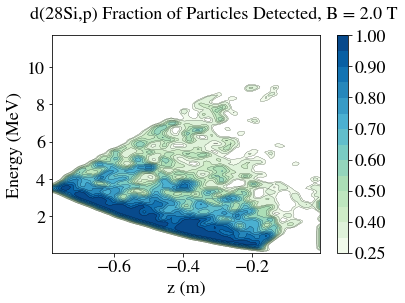

In [19]:
plot(outdir + writefile + ".pkl", "")